In [2]:
import re
import os
import tarfile
import pandas
import seaborn
import csv
import matplotlib.pyplot as plt
import shutil
import multiprocessing
import numpy as np
from textwrap import wrap
import warnings

In [3]:
#DATAFRAME MANIPULATION FUNCTIONS

#combine all dataframes in a directory
def combine_dfs(dir_path):
    main_df = df = pandas.DataFrame(columns = ['RANK', 'MSG', 'SIZE', 'DURATION [s]', 'AVG DURATION [s]', 'STRATEGY', 'TOL', 'NUMFILES','NODES','PROCS','PROCSperNODE'])
    for filename in os.listdir(dir_path):
        if(filename.split(".")[1] == "csv"):
            df = pandas.read_csv(dir_path + filename)
            main_df = main_df.append(df, ignore_index=True)
    combined_df = os.path.join(dir_path, "combined_df.csv")
    main_df.to_csv(combined_df, index=None) 
    
    
    
def get_app_report_filename_args(filename):
    inits = re.compile("(\w+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+).csv")
    get_inits = inits.search(filename)
    if(get_inits is not None):
        test_id = str(get_inits.group(1))
        job_id = int(get_inits.group(2))
        nodes = int(get_inits.group(3))
        ppn = int(get_inits.group(4))
        h = int(get_inits.group(5))
        m = int(get_inits.group(6))
        title = str(test_id)+'-'+str(nodes)+'-'+str(ppn)+'-'+str(h)+'-'+str(m)
        return title

#https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
def wrap_labels(ax, width):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width))
    ax.set_xticklabels(labels, rotation=0)
    

def make_csv(intxt):
    read_file = pandas.read_csv(intxt)
    read_file.to_csv(intxt[:-3] + 'csv', index=None)

Important Notes for outside verification:
- I found out through hand calculations that usually the highest rank (which also has the largest file) is usually in the cmd queue first (cmd[0])- from the looks of work_queue.cpp the queue is FIFO order. Things get added to the back of the list and popped of the front. Therefore when first looking at the starting local offsets from where to write/etc, remember these may not line up cleanly as you first expect

In [28]:
make_csv("/home/mikailg/ECE8650/optimizing_checkpoint_restart_project/training_data/combined_training_data.txt")
make_csv("/home/mikailg/ECE8650/optimizing_checkpoint_restart_project/file_per_proc_fix.txt")
df = pandas.read_csv("/home/mikailg/ECE8650/optimizing_checkpoint_restart_project/file_per_proc_fix.csv")
df = df.assign(writers=lambda x: x['processes'])
df = df.assign(nfiles=lambda x: x['processes'])
df = df.assign(nodes=lambda x: (x['processes']/8).astype(int))
df = df[['strategy','level','tolerance','nfiles','nodes','processes','writers','ckpt size','avg ckpts time [s]','max ckpt time [s]','avg BW [GB/s]','min BW [GB/s]']]
df_new = pandas.read_csv("/home/mikailg/ECE8650/optimizing_checkpoint_restart_project/training_data/combined_training_data.csv")
combine_df = df
combine_df = combine_df.append(df_new)
update = combine_df['strategy'] == 'AGGR_THREAD_PER_FILE'
combine_df.loc[update, ['nfiles']] = 8
combine_df.to_csv("/home/mikailg/ECE8650/optimizing_checkpoint_restart_project/training_data/combined_training_data.csv", index=None)


In [7]:
##PRINT GRAPHS FOR A SINGLE CSV##

#display duration of all measures operated 
def all_msgs_duration_all(intxt): 
    df = pandas.read_csv(intxt)
    plt.clf()
    plt.figure(figsize=(20,4))
    plot = seaborn.barplot(x='MSG', y='DURATION [s]', hue='RANK', ci=None, data=df)
    plt.legend(loc="upper left")
    plot.set(xlabel='Operation', ylabel='DURATION [s]', title='ALL OPS COMPARISON')
    plot.figure.tight_layout()
    plot.figure.savefig(intxt[:-4]+"POSIX_AGGR_MULT_OP_TOTAL_COMPARISON_BY_RANK.svg")
    

#Compare the operations of two ranks
def all_msg_duration_compare(intxt, slow_rank, fast_rank):
    df = pandas.read_csv(intxt)
    slow_rank_df = df.loc[df['RANK'] == slow_rank]
    fast_rank_df = df.loc[df['RANK'] == fast_rank]
    plt.rcParams["figure.figsize"] = [20.50, 10.00]
    fig, axs = plt.subplots(2,1)
    slow_plot = seaborn.barplot(x='MSG', y='DURATION [s]', ci=True, data=slow_rank_df, ax=axs[0])
    fast_plot = seaborn.barplot(x='MSG', y='DURATION [s]', ci=True, data=fast_rank_df, ax=axs[1])
    plt.legend(loc="upper left")
    slow_plot.set(xlabel='Operation', ylabel='DURATION [s]', title='NODE ID: '+str(slow_rank)+'--ALL OPS COMPARISON')
    fast_plot.set(xlabel='Operation', ylabel='DURATION [s]', title='NODE ID: '+str(fast_rank)+'--ALL OPS COMPARISON')
    slow_plot.figure.tight_layout()
    fast_plot.figure.tight_layout()
    plt.show()
    plt.savefig(intxt[:-4]+"OPERATION_COMPARISON.svg")

#Display the duration for a single operation across all ranks
def msg_duration_all(intxt, msg, title):
    df = pandas.read_csv(intxt)
    msg_df = df.loc[df['MSG'].str.contains(msg)]
    n = len(pandas.unique(msg_df['RANK']))
    print("number of leaders: " + str(n))
    plt.clf()
    plt.figure(figsize=(50,5))
    plot = seaborn.barplot(x='RANK', y='DURATION [s]', ci=None, data=msg_df)
    plt.legend(loc="upper left")
    plot.set(xlabel='RANK', ylabel='DURATION [s]', title= str(msg)+' COMPARISON')
    plot.figure.tight_layout()
    plot.set_title(msg+"--"+title, loc='left')
    plt.show()
    plot.figure.savefig(intxt[:-4]+str(msg)+"_TOTAL_BY_RANK.svg")
    
def msg_val_all(intxt, msg, val):
    df = pandas.read_csv(intxt)
    msg_df = df.loc[df['MSG'].str.contains(msg)]
    val_df = msg_df.loc[df['DURATION [s]'] > 50]
    val_df = val_df.loc[df['DURATION [s]'] <= val]
    print(val_df)
    n = len(pandas.unique(val_df['RANK']))
    plt.clf()
    plt.figure(figsize=(20,4))
    plot = seaborn.barplot(x='SIZE', y='DURATION [s]', hue='TOL', ci=None, data=val_df)
    plt.legend(loc="upper left")
    plot.set(xlabel='SIZE', ylabel='DURATION [s]', title= str(msg)+' COMPARISON')
    plot.figure.tight_layout()

#Display the duration for a single operation across only leaders
def ckpt_duartion_leaders(intxt, filter_, msg, title):
    df = pandas.read_csv(intxt)
    rank_list = df.loc[df['MSG'].str.contains(filter_)]['RANK'].tolist()
    # msgs_dict = {}
    # for m in msgs:
    #     msgs_dict[m] = dff[df['MSG'].str.contains(m)]
    ckpt_total_df = df[df['MSG'].str.contains(msg)]
    ckpt_total_df = ckpt_total_df.loc[ckpt_total_df['RANK'].isin(rank_list)]
    
    #get max throughput (total size / slowest backend)
    # max_throughputs_df = max_throughputs_df = df[df['MSG'].str.contains('CKPT COMPLETE')]
    # fast = max_throughputs_df['DURATION [s]'].idxmin()
    # slow = max_throughputs_df['DURATION [s]'].idxmax()
    # ckpt_total_df = ckpt_total_df.append(max_throughputs_df.loc[[fast] * 1].assign(RANK='FASTEST =' + str(max_throughputs_df['RANK'].loc[fast])), ignore_index=True)
    # ckpt_total_df = ckpt_total_df.append(max_throughputs_df.loc[[slow] * 1].assign(RANK='SLOWEST =' + str(max_throughputs_df['RANK'].loc[slow])), ignore_index=True)
    
    ckpt_total_df['SIZE'] = ckpt_total_df['SIZE'].div(10 ** 9)
    ckpt_total_df = ckpt_total_df.assign(THROUGHPUT=lambda x: x['SIZE']/ x['DURATION [s]'])
    n = len(pandas.unique(ckpt_total_df['RANK']))
    #print("number of leaders: " + str(n))
    plt.clf()
    plt.figure(figsize=(8,3))
    plot = seaborn.barplot(x='RANK', y='DURATION [s]', ci=None, data=ckpt_total_df)
    wrap_labels(plot.axes, 7)
    plt.legend(loc="upper left")
    plot.set(xlabel='RANK', ylabel='DURATION [s]')
    plot.axes.margins(y=0.3) # make room for the labels
    for bars in plot.axes.containers:
        plot.axes.bar_label(bars, fmt='%.3f', padding=5)
    plot.figure.tight_layout()
    plot.set_title(str(msg)+'-- LEADER COMPARISON', loc='left')
    plt.show()
    plot.figure.savefig(intxt[:-4]+"CKPT_TOTAL_BY_LEADER.svg")
    
#Thread breakdown of single rank if no msgs added, will only print the writes
def threads_breakdown_single(intxt, rank, msgs, compare):
    df = pandas.read_csv(intxt)
    rank_df = pandas.DataFrame(columns = ['RANK', 'LEADER ID', 'THREAD ID', 'MSG', 'SIZE', 'DURATION [s]', 'AVG DURATION [s]', 'STRATEGY', 'TOL', 'NUMFILES','NODES','PROCS','PROCSperNODE'])
    msgs_df = pandas.DataFrame(columns = ['RANK', 'LEADER ID', 'THREAD ID', 'MSG', 'SIZE', 'DURATION [s]', 'AVG DURATION [s]', 'STRATEGY', 'TOL', 'NUMFILES','NODES','PROCS','PROCSperNODE'])
    rank_df = df.loc[df['RANK'] == rank]
    rank_df['SIZE'] = rank_df['SIZE'].div(10 ** 9)
    ls = list()
    for m in msgs:
        if(compare is True and "WRITE" in m):
            m_df = rank_df.loc[rank_df['MSG'].str.contains(m)]
            m_df = m_df.loc[m_df['SIZE'] > 0]
            fast = m_df['DURATION [s]'].idxmin()
            slow = m_df['DURATION [s]'].idxmax()
            msgs_df = msgs_df.append(m_df.loc[[fast] * 1].assign(MSG=str(m_df['THREAD ID'].loc[fast])+str(m)), ignore_index=True)
            msgs_df = msgs_df.append(m_df.loc[[slow] * 1].assign(MSG=str(m_df['THREAD ID'].loc[slow])+str(m)), ignore_index=True)
            ls.append(str(m_df['THREAD ID'].loc[fast])+str(m)) 
            ls.append(str(m_df['THREAD ID'].loc[slow])+str(m))
        msgs_df = msgs_df.append(rank_df.loc[rank_df['MSG'].str.contains(m)])
        ls.append('AVG - ' + str(m))
    msgs_df = msgs_df.append(rank_df.loc[df['MSG'].str.contains('CKPT COMPLETE')], ignore_index=True)
    ls.append('CKPT COMPLETE')
    msgs_df = msgs_df.assign(THROUGHPUT=lambda x: x['SIZE']/ x['DURATION [s]'])    
    plt.rcParams["figure.figsize"] = [30.50, 8.00]
    fig, axs = plt.subplots(1,2.5)
    for ax, col in zip(axs, ['DURATION [s]', 'THROUGHPUT', 'SIZE']):
        labels = [ '\n'.join(wrap(l,8)) for l in ls]
        seaborn.barplot(
            x='MSG',
            y=col,
            data=msgs_df,
            ci=95,
            ax=ax
        )
        ax.set_xticklabels(labels, rotation=30)
        ax.set(xlabel='  ', ylabel=col)
        ax.set_title('NODE ID: '+str(rank)+' thread breakdowns--' + col)
        ax.margins(y=0.4) # make room for the labels
        for bars in ax.containers:
            ax.bar_label(bars, fmt='%.3f', padding=20)
    #plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
#Thread breakdown of single rank if no msgs added, will only print the writes
def all_threads_ops_breakdown(intxt, rank, msgs):
    df = pandas.read_csv(intxt)
    rank_df = pandas.DataFrame(columns = ['RANK', 'LEADER ID', 'THREAD ID', 'MSG', 'SIZE', 'DURATION [s]', 'AVG DURATION [s]', 'STRATEGY', 'TOL', 'NUMFILES','NODES','PROCS','PROCSperNODE'])
    msgs_df = pandas.DataFrame(columns = ['RANK', 'LEADER ID', 'THREAD ID', 'MSG', 'SIZE', 'DURATION [s]', 'AVG DURATION [s]', 'STRATEGY', 'TOL', 'NUMFILES','NODES','PROCS','PROCSperNODE'])
    rank_df = df.loc[df['RANK'] == rank]
    rank_df['SIZE'] = rank_df['SIZE'].div(10 ** 9)
    ls = list()
    for m in msgs:
        msgs_df = msgs_df.append(rank_df.loc[rank_df['MSG'].str.contains(m)])
        ls.append(str(m))
    msgs_df = msgs_df.append(rank_df.loc[df['MSG'].str.contains('CKPT COMPLETE')], ignore_index=True)
    ls.append('CKPT COMPLETE')
    msgs_df = msgs_df.assign(THROUGHPUT=lambda x: x['SIZE']/ x['DURATION [s]'])    
    plt.rcParams["figure.figsize"] = [28.50, 5.00]
    fig, axs = plt.subplots(1,3)
    for ax, col in zip(axs, ['DURATION [s]', 'THROUGHPUT', 'SIZE']):
        labels = [ '\n'.join(wrap(l,8)) for l in ls]
        seaborn.barplot(
            x='MSG',
            y=col,
            data=msgs_df,
            hue='THREAD ID',
            ci=95,
            ax=ax
        )
        ax.set_xticklabels(labels)
        ax.set(xlabel='  ', ylabel=col)
        ax.set_title('NODE ID: '+str(rank)+' thread breakdowns--' + col)
        ax.margins(y=0.4) # make room for the labels
        #for bars in ax.containers:
        #    ax.bar_label(bars, fmt='%.3f', padding=5)
    plt.tight_layout()
    plt.show()

In [14]:
# ##TESTING##
# warnings.filterwarnings("ignore")
# path="/home/mikailg/ANL/csvs/small_scale_multinode_original_v_aggregation_desyncdx2_2_11_23/"
# inits = re.compile("(\w+)-(\w+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)--(\d+)-(\d+)_(\d+)-(\d+)")
# for file in os.listdir(path):
#     get_inits = inits.search(file)
#     if(get_inits is not None):
#         test_id = str(get_inits.group(1))
#         test_strat = str(get_inits.group(2))
#         tol = int(get_inits.group(3))
#         num_files = int(get_inits.group(4))
#         nodes = int(get_inits.group(5))
#         ppn = int(get_inits.group(6))
#         procs = int(get_inits.group(7))
#         h = int(get_inits.group(10))
#         m = int(get_inits.group(11))
#         if(file[-3:] == "csv"):
#             title = 'graphing log: '+str(test_id)+'-'+str(test_strat)+"-"+str(tol)+'-'+str(num_files)+'-'+str(nodes)+'-'+str(ppn)+'-'+str(procs)+'-'+str(h)+'-'+str(m)
#             if(tol == 0):
#                 print(file)
#                 threads_breakdown_single(path+file, 0, ['WRITE TOTAL', 'WRITING THREAD TOTAL', 'LOCAL READ'], True)
# ##END TESTING

In [15]:
def threads_breakdown_compare(intxt, rank_slow, rank_fast, msgs, compare):
    df = pandas.read_csv(intxt)
    slow_rank_df = df.loc[df['RANK'] == rank_slow]
    slow_rank_df['SIZE'] = slow_rank_df['SIZE'].div(10 ** 9)
    
    fast_rank_df = df.loc[df['RANK'] == rank_fast]
    fast_rank_df['SIZE'] = fast_rank_df['SIZE'].div(10 ** 9)
    
    for d in [slow_rank_df, fast_rank_df]:
        ls = list()
        msgs_df = pandas.DataFrame(columns = ['RANK', 'LEADER ID', 'THREAD ID', 'MSG', 'SIZE', 'DURATION [s]', 'STRATEGY', 'TOL', 'NUMFILES','NODES','PROCS','PROCSperNODE'])
        rank = d['RANK'].loc[d.index[0]]
        overall = d.loc[d['MSG'].str.contains("WRITE THREAD LOOP")]
        fast = overall['DURATION [s]'].idxmin()
        slow = overall['DURATION [s]'].idxmax()
        fast_tid = d['THREAD ID'].loc[fast]
        slow_tid = d['THREAD ID'].loc[slow]
        for m in msgs:
            if(compare is True and "WRITE" in m):
                m_df = d.loc[d['MSG'].str.contains(m)]
                slow_df = m_df.loc[m_df['THREAD ID'] == slow_tid] 
                fast_df = m_df.loc[m_df['THREAD ID'] == fast_tid]
                msgs_df = msgs_df.append(slow_df.assign(MSG=str(slow_tid)+' (S)-'+str(m)), ignore_index=True)
                msgs_df = msgs_df.append(fast_df.assign(MSG=str(fast_tid)+' (F)-'+str(m)), ignore_index=True)
                ls.append(str(slow_tid)+'  (S)-'+str(m)) 
                ls.append(str(fast_tid)+'  (F)-'+str(m))
            msgs_df = msgs_df.append(d.loc[d['MSG'].str.contains(m)])
            ls.append('AVG - ' + str(m))
        msgs_df = msgs_df.append(d.loc[df['MSG'].str.contains('CKPT COMPLETE')], ignore_index=True)
        ls.append('CKPT COMPLETE')
        msgs_df = msgs_df.assign(THROUGHPUT=lambda x: x['SIZE']/ x['DURATION [s]'])
        plt.rcParams["figure.figsize"] = [28.50, 5.00]
        fig, axs = plt.subplots(1,3)
        for ax, col in zip(axs, ['DURATION [s]', 'THROUGHPUT', 'SIZE']):
            labels = [ '\n'.join(wrap(l,8)) for l in ls]
            seaborn.barplot(
                x='MSG',
                y=col,
                data=msgs_df,
                ci=95,
                ax=ax,
                palette="flare"
            )
            ax.set_xticklabels(labels, rotation=30)
            ax.set(xlabel='  ', ylabel=col)
            ax.set_title('NODE ID: '+str(rank)+' operation comparisons--' + col)
            ax.margins(y=0.3) # make room for the labels
            for bars in ax.containers:
                ax.bar_label(bars, fmt='%.3f', padding=5)
        plt.tight_layout()
        plt.show()  

In [16]:
warnings.filterwarnings("ignore")
path="/home/mikailg/ANL/csvs/aggregated_vary_num_writers_faux_buffs_retest-650301-8-8-28-03/"
#inits = re.compile("(\w+)-(\w+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)_(\d+)-(\d+)-(\w+)")
inits = re.compile("(\w+)-(\w+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)_(\d+)-(\d+)-(\w+)")
for file in os.listdir(path):
    get_inits = inits.search(file)
    if(get_inits is not None):
        test_id = str(get_inits.group(0))
        print(test_id)
        test_strat = str(get_inits.group(2))
        tol = int(get_inits.group(3))
        num_files = int(get_inits.group(4))
        ppn = int(get_inits.group(5))
        procs = int(get_inits.group(6))
        nodes=procs/ppn
        h = int(get_inits.group(10))
        m = int(get_inits.group(11))
        write_strat = get_inits.group(12)
        if(file[-3:] == "csv"):
            title = 'graphing log: '+str(test_id)+'-'+str(test_strat)+"-"+str(tol)+'-'+str(num_files)+'-'+str(nodes)+'-'+str(ppn)+'-'+str(procs)+'-'+str(h)+'-'+str(m)
            if(test_strat == 20):
                print(title)
                ckpt_duartion_leaders(path+file, "WRITE THREAD", "CKPT COMPLETE", "largescale testing")
                #threads_breakdown_compare(path+file, 711, 713, ['WRITE THREAD -- LOCAL', 'WRITE THREAD -- QUEUE', 'WRITE THREAD LOOP', 'RECV THREAD LOOP'], True)
                # for i in range(0,8):
                #     all_threads_ops_breakdown(path+file, i, ['WRITE THREAD -- LOCAL', 'WRITE THREAD -- QUEUE', 'WRITE THREAD LOOP', 'RECV THREAD LOOP'])
                #     all_threads_ops_breakdown(path+file, i, ['WRITE THREAD -- LOCAL', 'WRITE THREAD LOOP'])

AGGREGATED-10-1-1-8-8-1-28-03_15-19-undef
AGGREGATED-20-1-1-8-8-4-28-03_15-39-undef
AGGREGATED-10-1-1-8-8-4-28-03_15-20-undef
AGGREGATED-0-1-1-8-8-4-28-03_15-58-undef


In [17]:
# ##TESTING##
# path="/home/mikailg/ANL/csvs/largescale_disjoint_cpus_separated_logs_1024-8_1-20/"
# ckpt_duartion_leaders("/home/mikailg/ANL/csvs/largescale_disjoint_cpus_separated_logs_1024-8_1-20/largescale_disjoint_cpu_set_separate_logs-AGGR_POSIX_MULT-0-160-256-8-2048-10-15.csv", "WRITING THREAD TOTAL", "test")

# for file in os.listdir(path):
#     if(file[-3:] == "csv"):
#         inits = re.compile("(\w+)-(\w+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)")
#         get_inits = inits.search(file)
#         test_id = str(get_inits.group(1))
#         test_strat = str(get_inits.group(2))
#         tol = int(get_inits.group(3))
#         num_files = int(get_inits.group(4))
#         nodes = int(get_inits.group(5))
#         ppn = int(get_inits.group(6))
#         procs = int(get_inits.group(7))
#         h = int(get_inits.group(8))
#         m = int(get_inits.group(9))
#         if(file[-3:] == "csv" and h == 10 and m == 15):
#             threads_breakdown_compare(path+file, 8, 24, ['WRITE TOTAL', 'WRITING THREAD TOTAL'], True)
# ##END TESTING

In [18]:
def analyze_offsets(csv):
    df = pandas.read_csv(csv)
    plt.rcParams["figure.figsize"] = [35.50, 8.00]
    fig, axs = plt.subplots(2,1)
    for ax, col in zip(axs, ['OFFSET JUMPS', 'UNALIGNED WRITES']):
        seaborn.barplot(
            x='RANK',
            y=col,
            data=df,
            hue='THREAD ID',
            ci=95,
            ax=ax
        )
        ax.set(xlabel='  ', ylabel=col)
        ax.set_title('offset analysis (' + str(col) + ') per leader')
    plt.tight_layout()
    plt.show()

In [19]:
warnings.filterwarnings("ignore")
# path="/home/mikailg/ANL/csvs/largescale_fileperthread_retest-648910-1024-8-16-03/offsets/"
# inits = re.compile("(\w+)-(\w+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)-(\d+)_(\d+)-(\d+)-(\w+)")
# for file in os.listdir(path):
#     get_inits = inits.search(file)
#     if(get_inits is not None):
#         test_id = str(get_inits.group(1))
#         test_strat = str(get_inits.group(2))
#         tol = int(get_inits.group(3))
#         num_files = int(get_inits.group(4))
#         #nodes = int(get_inits.group(5))
#         ppn = int(get_inits.group(6))
#         procs = int(get_inits.group(7))
#         nodes=int(procs/ppn)
#         h = int(get_inits.group(9))
#         m = int(get_inits.group(10))
#         if(file[-3:] == "csv"):
#             title = 'graphing log: '+str(test_id)+'-'+str(test_strat)+"-"+str(tol)+'-'+str(num_files)+'-'+str(nodes)+'-'+str(ppn)+'-'+str(procs)+'-'+str(h)+'-'+str(m)
#             print(title)
#             analyze_offsets(path+file)

In [83]:
def app_minimum_throughput_single(intxt):
    df = pandas.read_csv(intxt[:-3] + 'csv')
    df_local = df.loc[df['level'] == 'local']
    df_total = df.loc[df['level'] == 'total']
    df_final = df_total.loc[df_total['num threads'] == 8]
    fig, axs = plt.subplots(1,1)
    plt.rcParams["figure.figsize"] = [10.00, 5.50]
    plot = seaborn.barplot(
            x='num files',
            y='min BW [GB/s]',
            data=df_final,
            hue='tolerance',
            ci=95,
        )
    plot.set(xlabel='FILES PER LEADER', ylabel='MAX BW [GB/s]')
    plot.set_title('FILES PER LEADER SCALABILITY TESTING')
    plot.margins(y=0.3) # make room for the labels
    for bars in plot.containers:
        plot.bar_label(bars, fmt='%.3f', label_type='center')
    plt.tight_layout()
    plt.show()
    
#compare stat files of two different test runs
def app_metric_compare(dfs, titles, labels, y_ax, x_ax):
    plt.rcParams["figure.figsize"] = [20.00, 5.50]
    fig, axs = plt.subplots(1,len(dfs))
    n = 256
    for ax, title, dat, ls in zip(axs, titles, dfs, labels):
        df = pandas.read_csv(dat)
        df_total = df.loc[df['level'] == 'total']
        _labels = [ '\n'.join(wrap(l,21)) for l in ls]
        seaborn.barplot(
                x=x_ax,
                y=y_ax,
                data=df_total,
                hue='tolerance',
                ci=99,
                ax=ax
            )
        ax.set_xticklabels(_labels)
        ax.set(xlabel='  ')
        title = '\n'.join(wrap(title,22))
        ax.set_title(title +' -- STRATEGY COMPARISON ' + y_ax)
        ax.margins(y=0.1) # make room for the labels
        for bars in ax.containers:
            ax.bar_label(bars, fmt='%.3f', label_type='center')
    plt.tight_layout()
    plt.show()
    
#print subset of breakdowns (i.e. by threads numbers, block size, etc)
def app_metric_compare_features(df_main, labels, y_ax, x_ax, cat, features, title_stem):
    _labels = [ '\n'.join(wrap(l,12)) for l in labels]
    plt.rcParams["figure.figsize"] = [20.00, 4.50]
    fig, axs = plt.subplots(1, len(features))
    for ax, feature in zip(axs, features):
        df = pandas.DataFrame()
        df = df.append(df_main.loc[df_main[cat] == feature])
        seaborn.lineplot(
                x=x_ax,
                y=y_ax,
                data=df,
                style='STRATEGY',
                hue='NUMBER OF THREADS',
                ci=None,
                palette='Set2',
                ax=ax
            )
        ax.legend(loc='upper right')
        ax.set_ylim(0, 3)
        ax.set_xlim(1, 64)
        ax.set(xlabel='# OF FOLLOWER NODES SENDING DATA (8 GB/node)', ylabel='AGGREGATED THROUGHPUT [GiB/s]')
        title = 'FILES PER LEADER = ' + str(feature)
        ax.set_title(title)
        ax.margins(y=0.5) # make room for the labels
        for bars in ax.containers:
            ax.bar_label(bars, fmt='%.3f',label_type='center')
    plt.tight_layout()
    plt.show()
    
    
def app_minimum_throughput_single_isolate(df, cat, feat):
    df_final = df.loc[df[cat] == feat]
    fig, axs = plt.subplots(1,1)
    plt.rcParams["figure.figsize"] = [10.00, 5.50]
    plot = seaborn.barplot(
            x='STRATEGY',
            y='LOCAL THROUGHPUT [GiB/s]',
            data=df_final,
            hue='NODES',
            ci=95,
        )
    #plot.set(xlabel='FILES PER LEADER', ylabel='MAX BW [GB/s]')
    plot.set_title('CONTIGUOUS TESTING')
    plot.margins(y=0.3) # make room for the labels
    for bars in plot.containers:
        plot.bar_label(bars, fmt='%.3f', label_type='center')
    plt.tight_layout()
    plt.show()


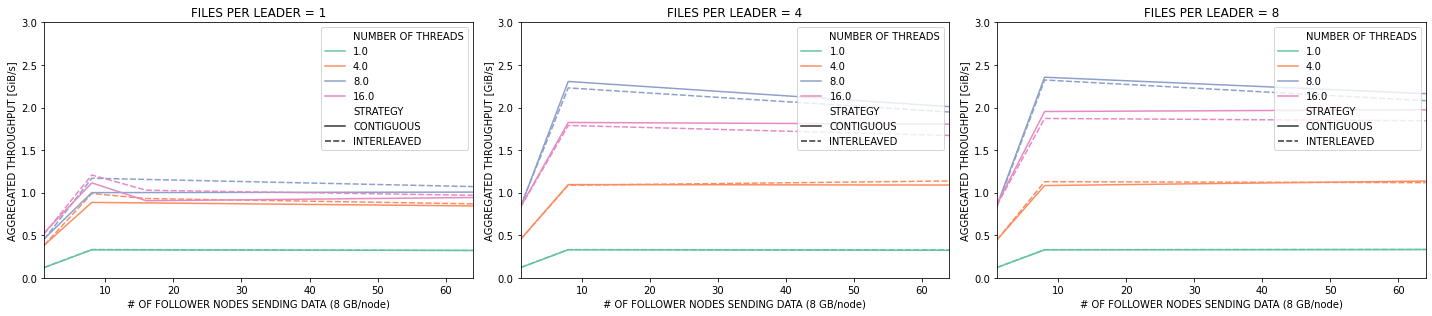

In [86]:
#OPENMP 
#make_csv("/home/mikailg/ANL/logs/openmp/combine.txt")
#combine 8 threads to other testing
make_csv("/home/mikailg/ANL/logs/openmp/n_files_thread_scaling.txt")
make_csv("/home/mikailg/ANL/logs/openmp/testing.txt")
df = pandas.read_csv("/home/mikailg/ANL/logs/openmp/testing.csv")
df = df.assign(NTHREADS=8,PPN=8)
df = df[['STRATEGY','NODES','PPN','NTHREADS','NUMBER OF FILES','TOLERANCE','LOCAL THROUGHPUT [GB/s]','RECEIVE THROUGHPUT [GB/s]']]
df.to_csv("/home/mikailg/ANL/logs/openmp/testing.csv", index=None)
df_new = pandas.read_csv("/home/mikailg/ANL/logs/openmp/n_files_thread_scaling.csv")
combine_df = df
combine_df = combine_df.append(df_new)
combine_df = combine_df.rename(columns={"NTHREADS": "NUMBER OF THREADS"})
new_df.to_csv("/home/mikailg/ANL/logs/openmp/new_combine.csv", index=None)

new_df.to_csv("/home/mikailg/ANL/logs/openmp/combine.csv", index=None)
df_1nodes = combine_df.loc[combine_df['NODES'] == 1]
df_8nodes = combine_df.loc[combine_df['NODES'] == 8]
df_16nodes = combine_df.loc[combine_df['NODES'] == 16]
df_64nodes = combine_df.loc[combine_df['NODES'] == 64]
df_1nodes = combine_df.assign(RECVSIZE=0,LOCALSIZE=8948560383)
df_8nodes = combine_df.assign(RECVSIZE=8114266573,LOCALSIZE=8948560383)
df_16nodes = combine_df.assign(RECVSIZE=125052328261,LOCALSIZE=8948560383)
df_64nodes = combine_df.assign(RECVSIZE=526906204721,LOCALSIZE=8948560383)
new_df = pandas.DataFrame(columns = ['STRATEGY','NODES','PPN','NTHREADS','NUMBER OF FILES','TOLERANCE','LOCAL THROUGHPUT [GB/s]','RECEIVE THROUGHPUT [GB/s]','RECVSIZE', 'LOCALSIZE'])
new_df = new_df.append(df_1nodes)
new_df = new_df.append(df_8nodes)
new_df = new_df.append(df_16nodes)
new_df = new_df.append(df_64nodes)
new_df = new_df.assign(AGG_THROUGHPUT=lambda x: ((x['RECEIVE THROUGHPUT [GB/s]'] * x['RECVSIZE']) +  (x['LOCAL THROUGHPUT [GB/s]'] * x['LOCALSIZE'])) / (x['RECVSIZE'] + x['LOCALSIZE']))
new_df.to_csv("/home/mikailg/ANL/logs/openmp/new_combine.csv", index=None)

df = pandas.read_csv("/home/mikailg/ANL/logs/openmp/new_combine.csv")
df_condense = df.loc[df['NUMBER OF THREADS'] < 64]
#for i in [1,4,16,64]:
#for i in [20]:
    # print("WRITER THREADS = " + str(8))
    # df_condense = df.loc[df['TOLERANCE'] == i]
    # # app_metric_compare_features("WRITER THREADS", i, df_condense,
    # #                               ["ALIGNED", "INTERLEAVED"],
    # #                               'LOCAL THROUGHPUT [GB/s]',
    # #                               'NODES',
    # #                               'NUM FILES', 
    # #                               [1,4,8],
    # #                               'SCALE FILES PER LEADER ')
    # # app_metric_compare_features("WRITER THREADS", i, df_condense,
    # #                               ["ALIGNED", "INTERLEAVED"],
    # #                               'RECEIVE THROUGHPUT [GB/s]',
    # #                               'NODES',
    # #                               'NUM FILES', 
    # #                               [1,4,8],
    # #                               'SCALE FILES PER LEADER ')
    # ### 8 threads ###
    # app_metric_compare_features("WRITER THREADS", 8, df_condense,
    #                               ["ALIGNED", "INTERLEAVED"],
    #                               'LOCAL THROUGHPUT [GB/s]',
    #                               'NODES',
    #                               'NUM FILES', 
    #                               [1,4,8],
    #                               'SCALE FILES PER LEADER ')
    # app_metric_compare_features("WRITER THREADS", 8, df_condense,
    #                               ["ALIGNED", "INTERLEAVED"],
    #                               'RECEIVE THROUGHPUT [GB/s]',
    #                               'NODES',
    #                               'NUM FILES', 
    #                               [1,4,8],
    #                               'SCALE FILES PER LEADER ')
    #     # app_minimum_throughput_single_isolate(df_condense, 'NUM FILES', 1)
        
app_metric_compare_features(df_condense,
                              ["CONTIGUOUS", "INTERLEAVED"],
                              'AGG_THROUGHPUT',
                              'NODES',
                              'NUMBER OF FILES', 
                              [1,4,8],
                              'SCALE FILES PER LEADER ')
        


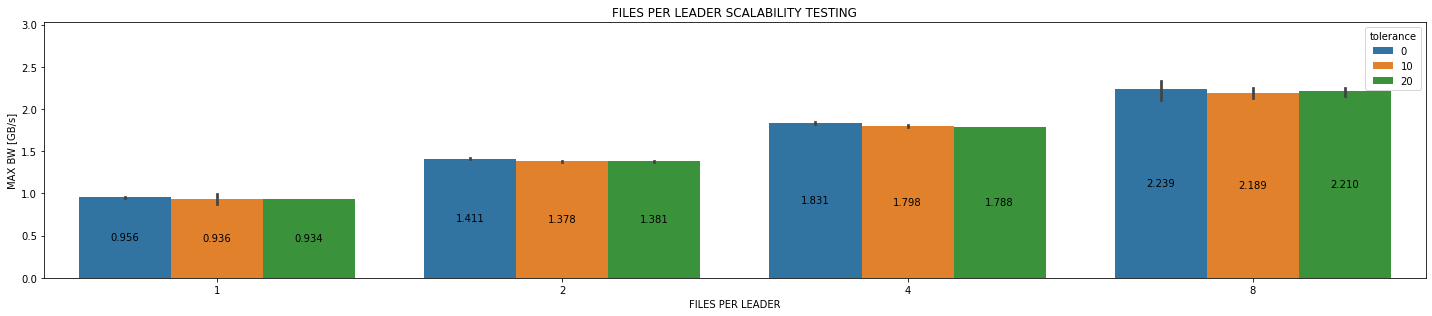

In [39]:
##TESTING##
#make_csv("/home/mikailg/ANL/logs/multi-threaded/thetagpu_comp_retest_woDBG-648278-8-8-10-03/thetagpu_comp_retest_woDBG-648278-8-8-10-03.txt")
# aligned_writes_small_scale="/home/mikailg/ANL/logs/multi-threaded/MPI_Barrier_testing_645846-8-8_02-17-23/"
# aligned_write_large_scale="/home/mikailg/ANL/logs/multi-threaded/largescale_aligned_writes_645767-1024-8-24-02/"
# aligned_leader_ratios="/home/mikailg/ANL/logs/multi-threaded/largescale_assigned_leader_ratio_646522-256-8-24-02/"
# thread_balancing="/home/mikailg/ANL/logs/multi-threaded/semi_largescale_thread_imbalance_retest-646882-256-8-28-02/"
# fugaku_based_alg="/home/mikailg/ANL/logs/multi-threaded/offset_analysis-647176-256-8-02-03/"

# files = [aligned_writes_small_scale+"MPI_Barrier_test-645846-8-8-17-02.csv",  
#          aligned_leader_ratios+"largescale_assigned_leader_ratio_8to1-646522-256-8-24-02.csv",
#          fugaku_based_alg+"offset_analysis-647176-256-8-02-03.csv"]
# titles = ["SMALL SCALE AGGREGATED (4 FILES) v ORIGINAL (64 FILES)", 
#           "AGGREGATED - SINGLE LOCAL FILE PER WRITER THREAD (32 FILES) v ORIGINAL (2048 FILES) -- 256 NODES",
#           "FUGAKU-BASED AGGREGATED - BALANCING SCHEME (1 FILES) -- 8 NODES"]
# labels=[["ORIGINAL", "AGGREGATED"],
#         ["ORIGINAL", "AGGREGATED"],
#     ["ORIGINAL", "FUGAKU BASED AGGREGATED"]]
# app_metric_compare(files, titles, labels, 'min BW [GB/s]', 'strategy')
# app_metric_compare_features(aligned_write_large_scale+"largescale_align_sends-645767-1024-8-24-02.csv", 
#                             [["ORIGINAL", "AGGREGATED"],["ORIGINAL", "AGGREGATED"],["ORIGINAL", "AGGREGATED"]], 
#                             'min BW [GB/s]', 
#                             'strategy', 
#                             'nodes', 
#                             [256, 512, 1024],
#                            "LARGE SCALE AGGREGATED SINGLE LOCAL FILE PER WRITER THREAD (160 FILES) v ORIGINAL")

# app_metric_compare_features(fugaku_based_alg+"offset_analysis-647176-256-8-02-03.csv",
#                                           [["ORIGINAL","AGGREGATED"],["ORIGINAL", "AGGREGATED"]],
#                                           'min BW [GB/s]',
#                                           'strategy', 
#                                           'nodes', 
#                                           [8,256],
#                                          "Small v Large scale, nonleader to leader ratio = 8")

# make_csv("/home/mikailg/ANL/logs/multi-threaded/full_files_per_leader-651046-8-8-05-04/full_files_per_leader-651046-8-8-05-04.txt")
# make_csv("/home/mikailg/ANL/logs/multi-threaded/full_files_per_leader_16threads-651051-8-8-05-04/full_files_per_leader_16threads-651051-8-8-05-04.txt")
# make_csv("/home/mikailg/ANL/logs/multi-threaded/stripe_retesting_c_eq_num_writers-650714-8-8-31-03/stripe_retesting_c_eq_num_writers-650714-8-8-31-03.txt")
# make_csv("/home/mikailg/ANL/logs/multi-threaded/stripe_retesting_c_eq_num_writers_defineS-650733-8-8-31-03/stripe_retesting_c_eq_num_writers_defineS-650733-8-8-31-03.txt")
# make_csv("/home/mikailg/ANL/logs/multi-threaded/stripe_retesting_S_eq_1G-650743-8-8-01-04/stripe_retesting_S_eq_1G-650743-8-8-01-04.txt")

# df = pandas.read_csv("/home/mikailg/ANL/logs/multi-threaded/full_files_per_leader-651046-8-8-05-04/full_files_per_leader-651046-8-8-05-04.csv")
# #for i in [1,2,4,8]:
# #print("# FILES PER LEADER = " + str(i))
# df_local = df.loc[df['level'] == 'local']
# df_total = df.loc[df['level'] == 'total']
# df_condense = df.append(df_total.loc[df_total['strategy'].str.contains("ORIG")])
# df_condense = df_total.loc[df_total['num threads'] == 8]
# app_metric_compare_features(df_condense,
#                               [["AGGREGATED", "FILE PER THREAD"],
#                                ["AGGREGATED", "FILE PER THREAD"]],
#                               'min BW [GB/s]',
#                               'strategy',
#                               'num threads', 
#                               [8,16],
#                               'STRIPE SETTINGS: C = num threads; S = 2G')

app_minimum_throughput_single("/home/mikailg/ANL/logs/multi-threaded/full_files_per_leader-651046-8-8-05-04/full_files_per_leader-651046-8-8-05-04.csv")





In [67]:
#Fugaku Printing
#forgot to replace procs per node modifier in test file
def replace_first_x(df, x, m):
    df['NODES'].iloc[:x] = df['NODES'].multiply(m)
    return df
     
def replace_last_x(df, x, m):
    df['NODES'].iloc[x:] = df['NODES'].multiply(m)
    df['PPN'].iloc[x:] = 4
    return df

def app_df_minimum_bw_compare_features(df, labels, cat, features):
    df_local = df.loc[df['STORAGE TIER'] == 'local']
    df_total = df.loc[df['STORAGE TIER'] == 'total']
    
    plt.rcParams["figure.figsize"] = [20.00, 4.50]
    fig, axs = plt.subplots(1,len(features))
    for ax, feature in zip(axs, features):
        df = df_total.loc[df_total[cat] == feature]
        seaborn.barplot(
                x='NODES',
                y='max BW',
                data=df_total,
                hue='TOLERANCE',
                ci=99,
                ax=ax
            )
        ax.set(xlabel='NODES', ylabel='MAX BW [GB/s]')
        ax.set_title('STRATEGY COMPARISON -- ' + str(cat) + ' = ' + str(feature))
        ax.margins(y=0.5) # make room for the labels
        for bars in ax.containers:
            ax.bar_label(bars, fmt='%.3f', label_type='center')
    plt.tight_layout()
    plt.show()

def fugaku_app_minimum_bw_compare_features(intxt, labels, cat, features):
    df = pandas.read_csv(intxt[:-3] + 'csv')
    df = df.assign(PPN=1)
    
    df = replace_first_x(df, 54, 8) #because I forgot to change PPN modifier from a constant in file (originally divides by 8) 
    df = replace_last_x(df,54,2)
    
    app_df_minimum_bw_compare_features(df, labels, cat, features)

In [60]:
##TESTING##
# path="/home/mikailg/ANL/logs/fugaku/fugaku-initial-largescale-testing-3Dtorus-20531754-4096-1_4-31-01/"
# fugaku_app_minimum_bw_compare_features(path+"fugaku-initial-largescale-testing-3Dtorus-20531754-4096-1_4-31-01.csv", [], 'PPN', [1,4])